In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/job-shop-cycle-time-dataset/jobshop_cycle_times.csv




## 1. Hypothesis Testing for Means in an Industrial Engineering Context  

In Industrial Engineering, we often want to know if a change in process design truly improves performance or if the observed difference is due to random chance.  

Suppose we implemented a new workstation layout and want to test if it reduced the average cycle time compared to the old layout.  



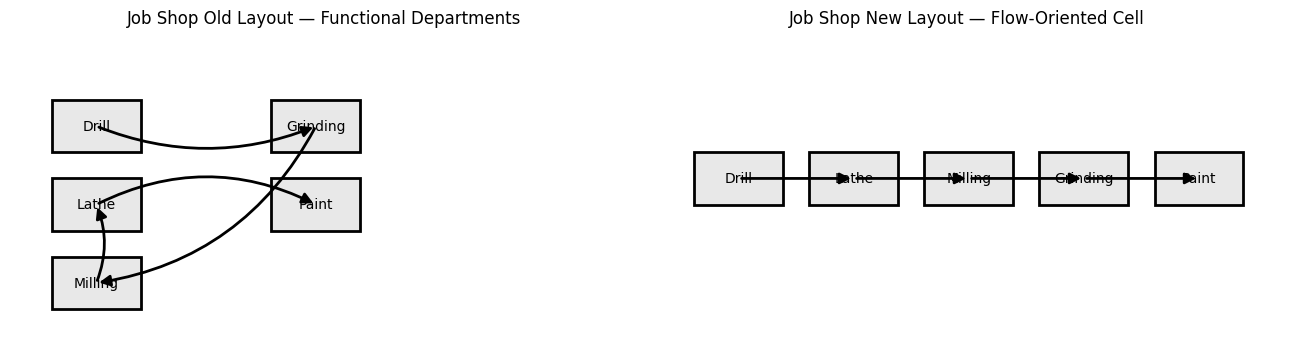

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

# ---------- Helpers ----------
BOX_W, BOX_H = 1.7, 1.0

def draw_stations(ax, stations, title):
    """Draw labeled rectangles for each station.
    stations: dict{name: (x_left, y_bottom)} in axis coords.
    Returns dict of station centers for arrow routing.
    """
    centers = {}
    for name, (x, y) in stations.items():
        ax.add_patch(Rectangle((x, y), BOX_W, BOX_H, ec='black', fc='#e8e8e8', lw=2))
        ax.text(x + BOX_W/2, y + BOX_H/2, name, ha='center', va='center', fontsize=10)
        centers[name] = (x + BOX_W/2, y + BOX_H/2)
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_aspect('equal')
    ax.axis('off')
    return centers


def route_arrows(ax, centers, sequence, curved=False):
    """Draw arrows following the sequence list of station names."""
    for i in range(len(sequence)-1):
        a, b = sequence[i], sequence[i+1]
        (x1, y1), (x2, y2) = centers[a], centers[b]
        if curved:
            # Alternate curvature to emphasize zig-zag transport
            rad = 0.2 if i % 2 == 0 else -0.25
            conn = f"arc3,rad={rad}"
        else:
            conn = "arc3,rad=0.0"
        arr = FancyArrowPatch(
            (x1, y1), (x2, y2),
            arrowstyle='-|>', mutation_scale=16,
            linewidth=2, color='black',
            connectionstyle=conn)
        ax.add_patch(arr)


# ---------- Layout A: Functional (by process type) with zig-zag flow ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

stations_A = {
    'Drill':   (0.8, 3.8),
    'Lathe':   (0.8, 2.3),
    'Milling': (0.8, 0.8),
    'Grinding':(5.0, 3.8),
    'Paint':   (5.0, 2.3),
}
centers_A = draw_stations(ax1, stations_A, 'Job Shop Old Layout — Functional Departments')
# Example non-linear routing through departments (back-and-forth typical of a functional job shop)
sequence_A = ['Drill', 'Grinding', 'Milling', 'Lathe', 'Paint']
route_arrows(ax1, centers_A, sequence_A, curved=True)

# ---------- Layout B: Flow-Oriented (linear/U-shaped cell) ----------
stations_B = {
    'Drill':   (0.8, 2.8),
    'Lathe':   (3.0, 2.8),
    'Milling': (5.2, 2.8),
    'Grinding':(7.4, 2.8),
    'Paint':   (9.6, 2.8),
}
centers_B = draw_stations(ax2, stations_B, 'Job Shop New Layout — Flow-Oriented Cell')
sequence_B = ['Drill', 'Lathe', 'Milling', 'Grinding', 'Paint']
route_arrows(ax2, centers_B, sequence_B, curved=False)

# Scene bounds
for ax in (ax1, ax2):
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 6)

plt.tight_layout()
plt.show()


## 2. Dataset Description  
The dataset includes cycle times from two groups:  
- Old Layout (before improvement)  
- New Layout (after improvement)  

Columns: 
- `layout_type` (old / new)  
- `cycle_time_s` (average cycle time in seconds per day)  
- `operator_id` (to capture operator variability)  
- `date` (to capture time trends)  



In [2]:
import pandas as pd

# Load the CSV (make sure you've uploaded it into the Kaggle environment)
df = pd.read_csv("/kaggle/input/jobshop-cycle-times-dataset/jobshop_cycle_times.csv")

# Round cycle times to the nearest hundreth
df["cycle_time_s"] = df["cycle_time_s"].round(2)

# Check the first few rows
df.head()

,layout_type,cycle_time_s,operator_id,date
0,old,54.21,Op3,1/1/2023
1,old,35.12,Op8,1/2/2023
2,old,48.47,Op10,1/3/2023
3,old,57.25,Op8,1/4/2023
4,old,43.78,Op9,1/5/2023



## 3. Exploratory Data Analysis (EDA)  
- Compute summary statistics: mean, median, standard deviation for each layout type.  
- Visualize:
  - Time series chart to see cycel times over time.
  - Boxplots comparing old vs. new cycle times.  
  - Histograms or density plots to observe distribution shapes. 

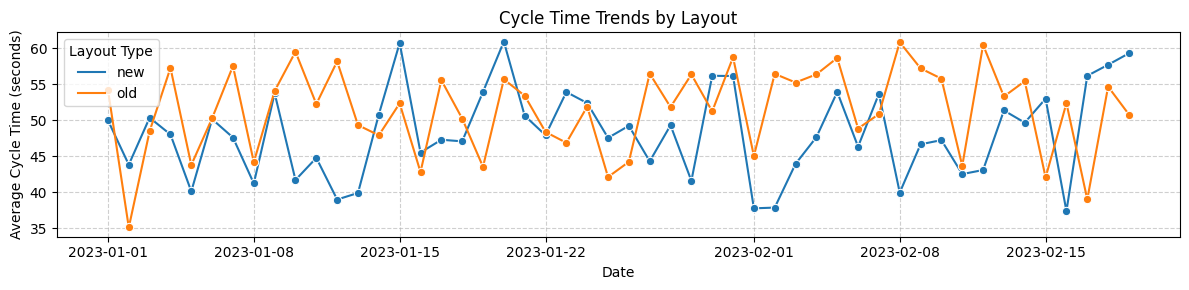

In [16]:


import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Ensure date column is datetime
df["date"] = pd.to_datetime(df["date"])

# Aggregate daily mean cycle times for each layout
trend = df.groupby(["date", "layout_type"])["cycle_time_s"].mean().reset_index()

# Plot
plt.figure(figsize=(12,3))
sns.lineplot(data=trend, x="date", y="cycle_time_s", hue="layout_type", marker="o")

plt.title("Cycle Time Trends by Layout")
plt.xlabel("Date")
plt.ylabel("Average Cycle Time (seconds)")
plt.legend(title="Layout Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



Summary statistics by layout_type:


,count,mean,std,min,25%,50%,75%,max
layout_type,,,,,,,,
new,50.0,48.2086,6.144688,37.38,43.850,47.775,52.8275,60.89
old,50.0,51.4004,6.006497,35.12,48.015,52.280,56.1925,60.81


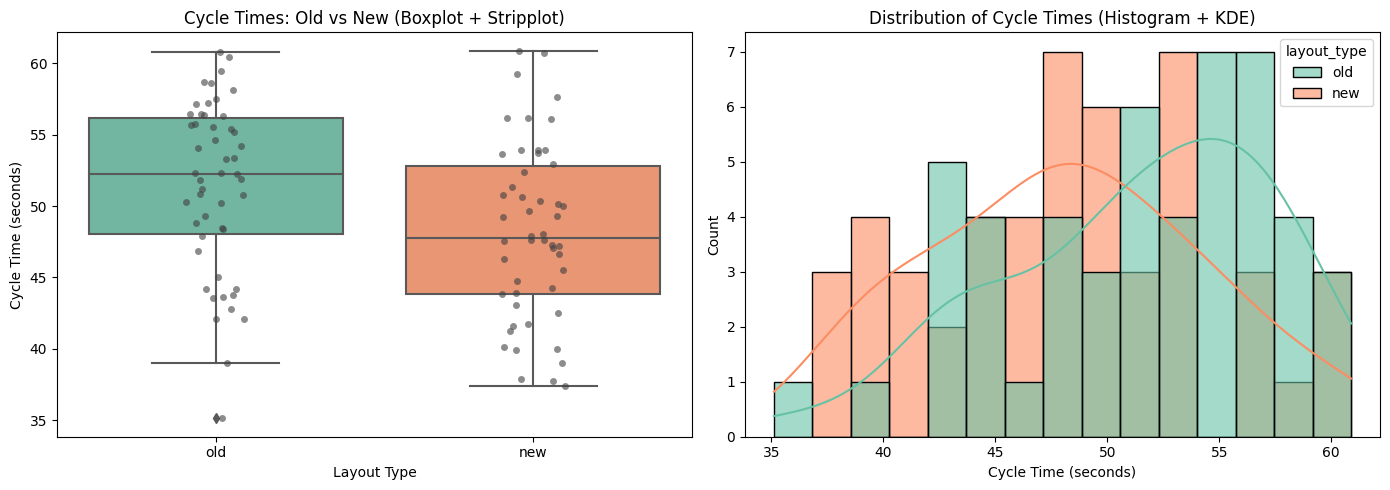

In [14]:
# --- Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

# Load the CSV
df = pd.read_csv("/kaggle/input/jobshop-cycle-times-dataset/jobshop_cycle_times.csv")

# Round cycle times to the nearest hundreth
df["cycle_time_s"] = df["cycle_time_s"].round(2)

# --- Summary statistics
print("\nSummary statistics by layout_type:")
display(df.groupby("layout_type")["cycle_time_s"].describe())

# --- Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Boxplot + Stripplot
sns.boxplot(data=df, x="layout_type", y="cycle_time_s", palette="Set2", ax=axes[0])
sns.stripplot(data=df, x="layout_type", y="cycle_time_s", color=".25", alpha=0.6, jitter=True, ax=axes[0])
axes[0].set_title("Cycle Times: Old vs New (Boxplot + Stripplot)")
axes[0].set_ylabel("Cycle Time (seconds)")
axes[0].set_xlabel("Layout Type")

# Right: Histogram with KDE overlay
sns.histplot(data=df, x="cycle_time_s", hue="layout_type", kde=True, bins=15, palette="Set2", alpha=0.6, ax=axes[1])
axes[1].set_title("Distribution of Cycle Times (Histogram + KDE)")
axes[1].set_xlabel("Cycle Time (seconds)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


## 4. Formulating Hypotheses  
We want to test whether the new layout reduces average cycle time.  

- Null Hypothesis (H₀): μ_old = μ_new (no difference in mean cycle time).  
- Alternative Hypothesis (H₁): μ_new < μ_old (old layout has a higher mean cycle time).  


## 5. Decision Logic For Tests

The decision logic acts as a roadmap:
1. Check normality → if not normal, decide based on sample size.  
2. Check equal variances → if unequal, use Welch’s test.  
3. If both assumptions hold → use Student’s t-test.  

This structured approach ensures that our hypothesis testing is both statistically sound and meaningful in practice.

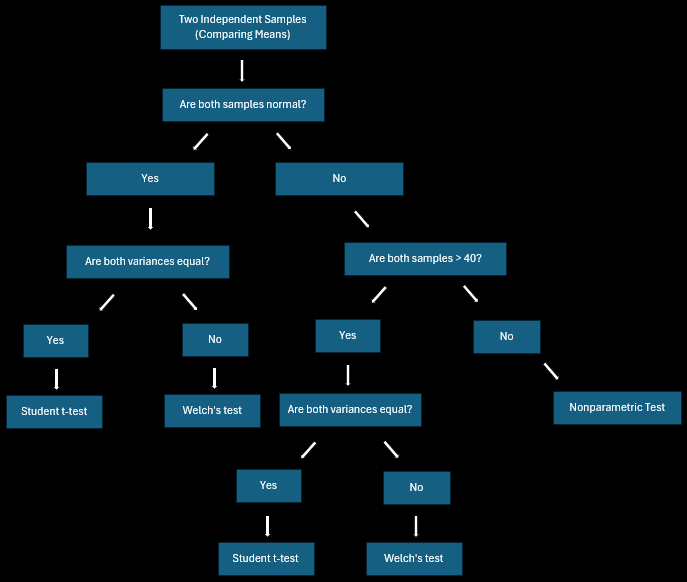
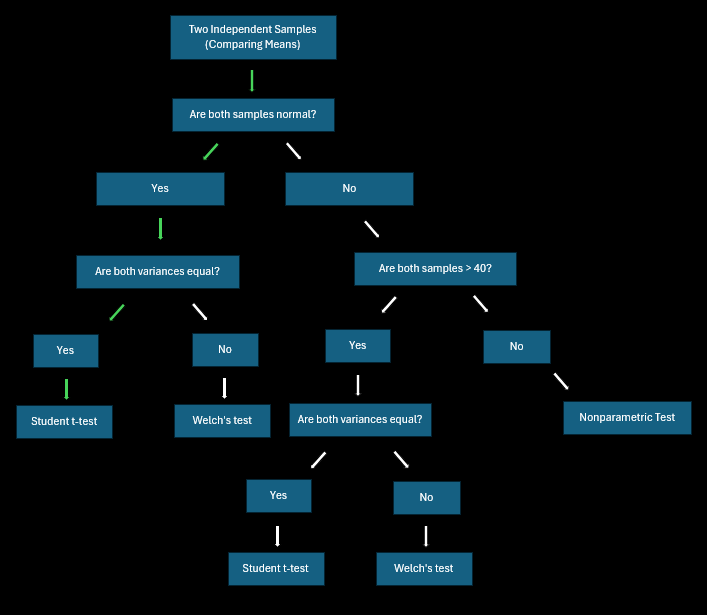
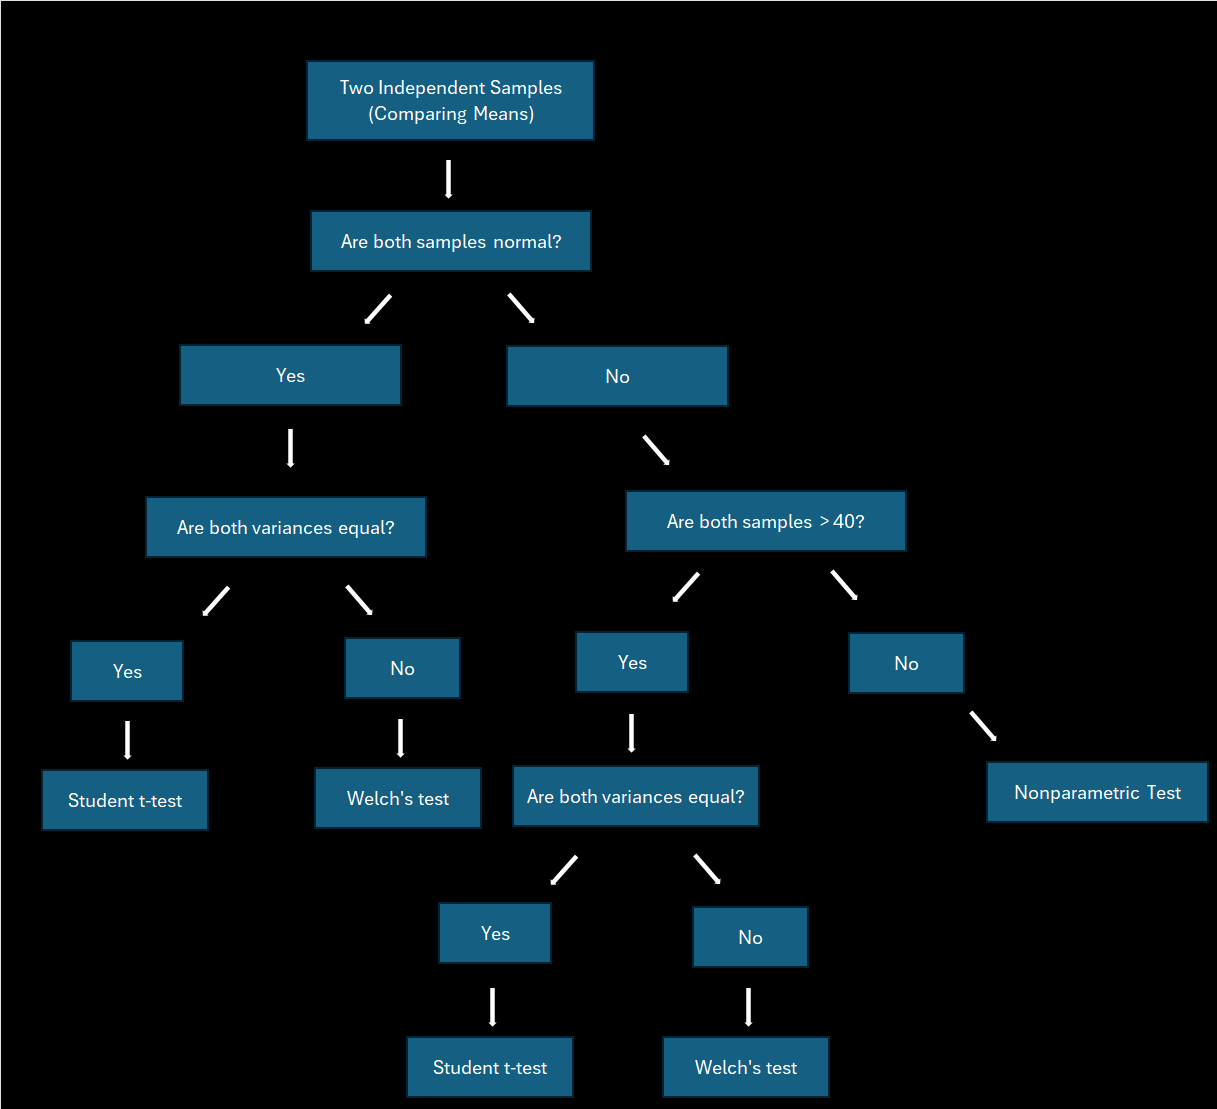
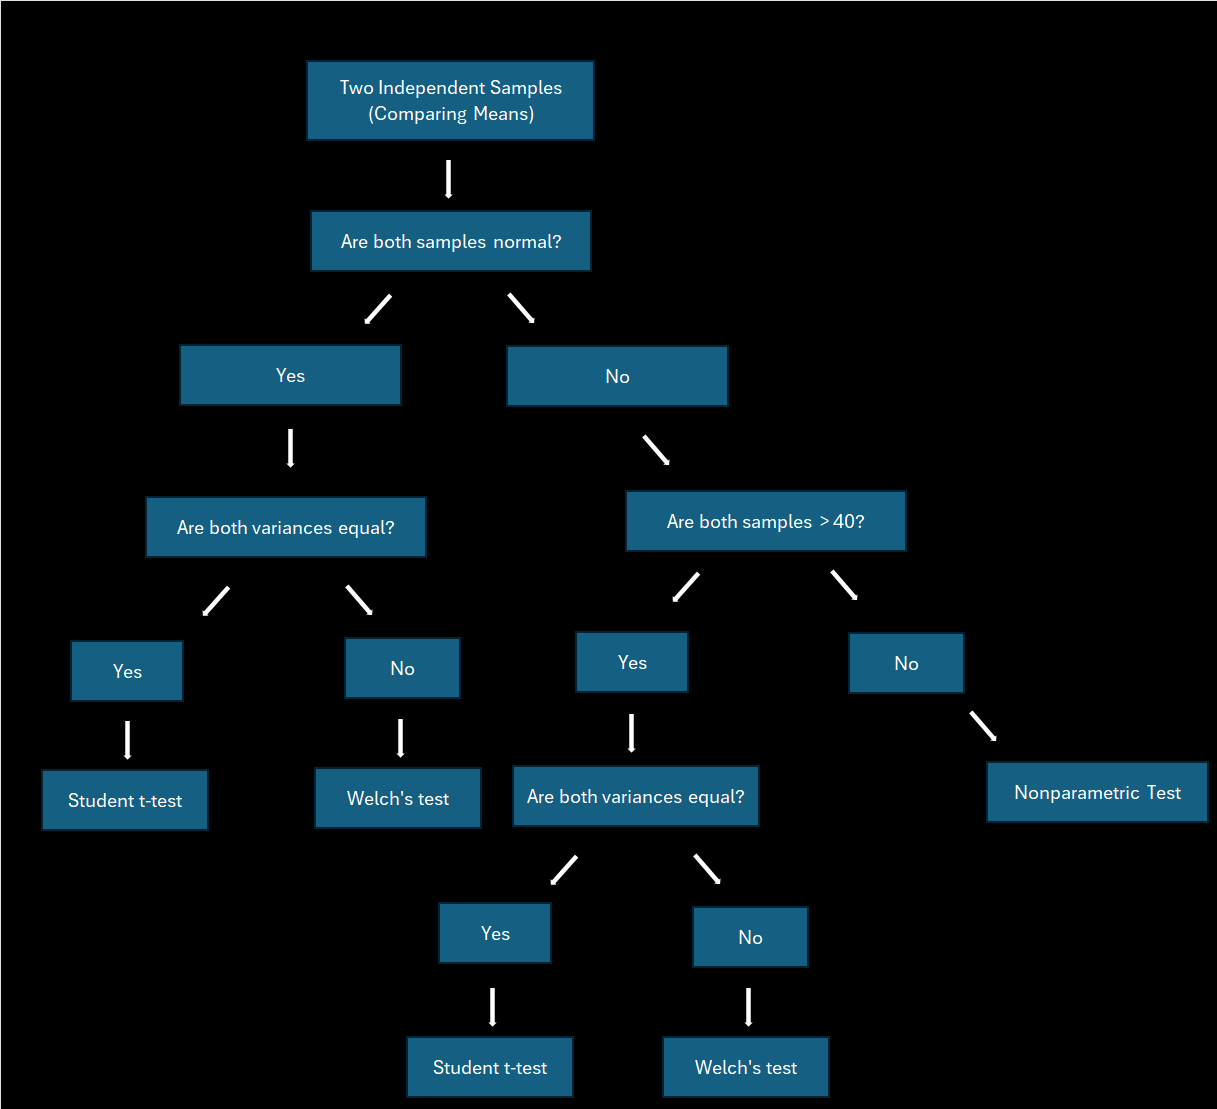
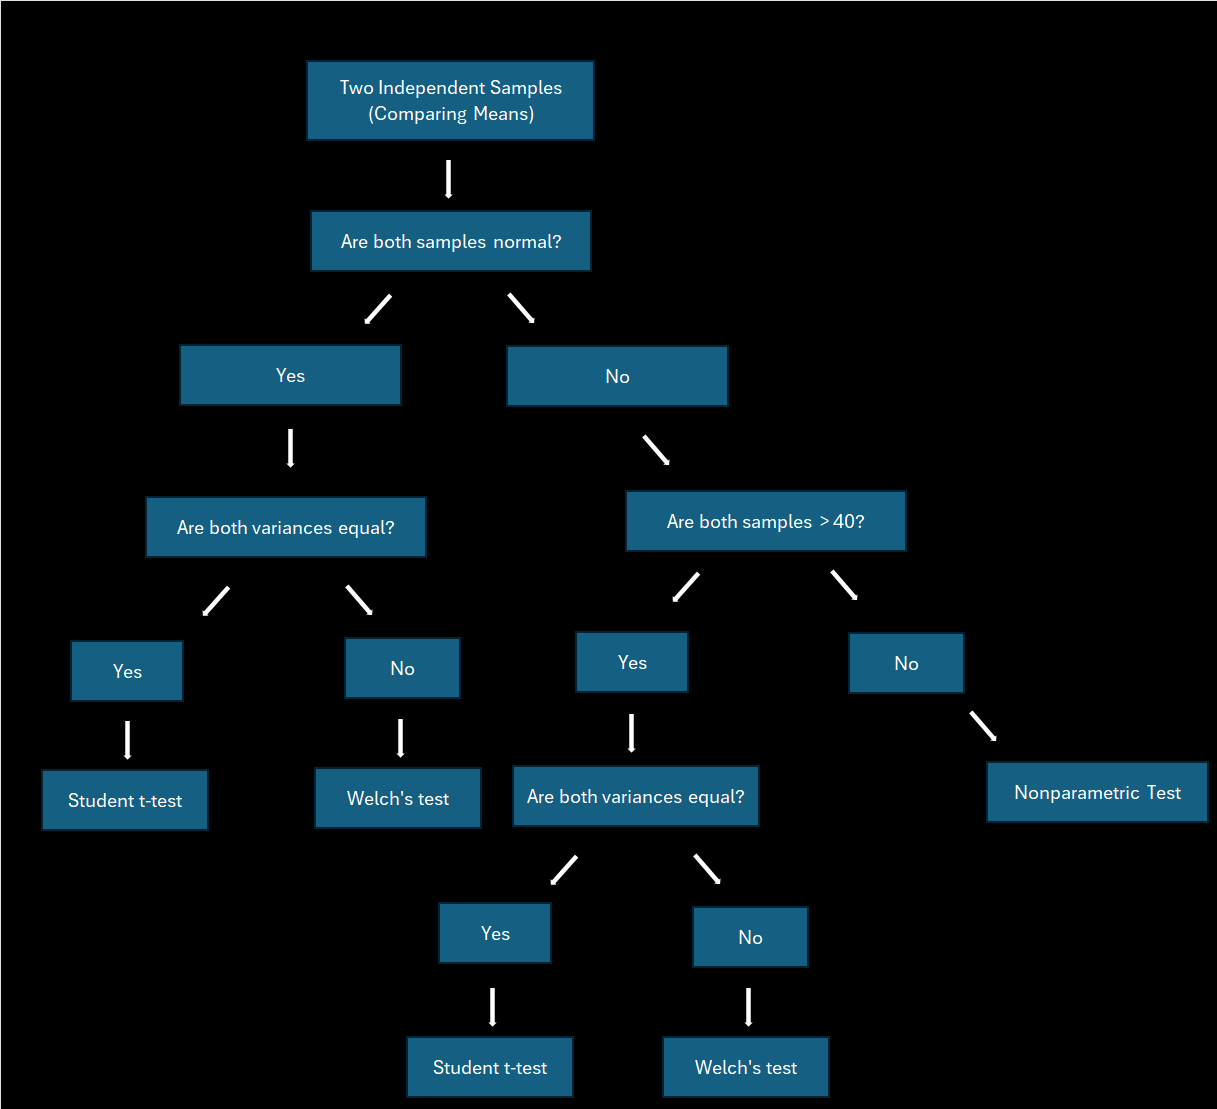
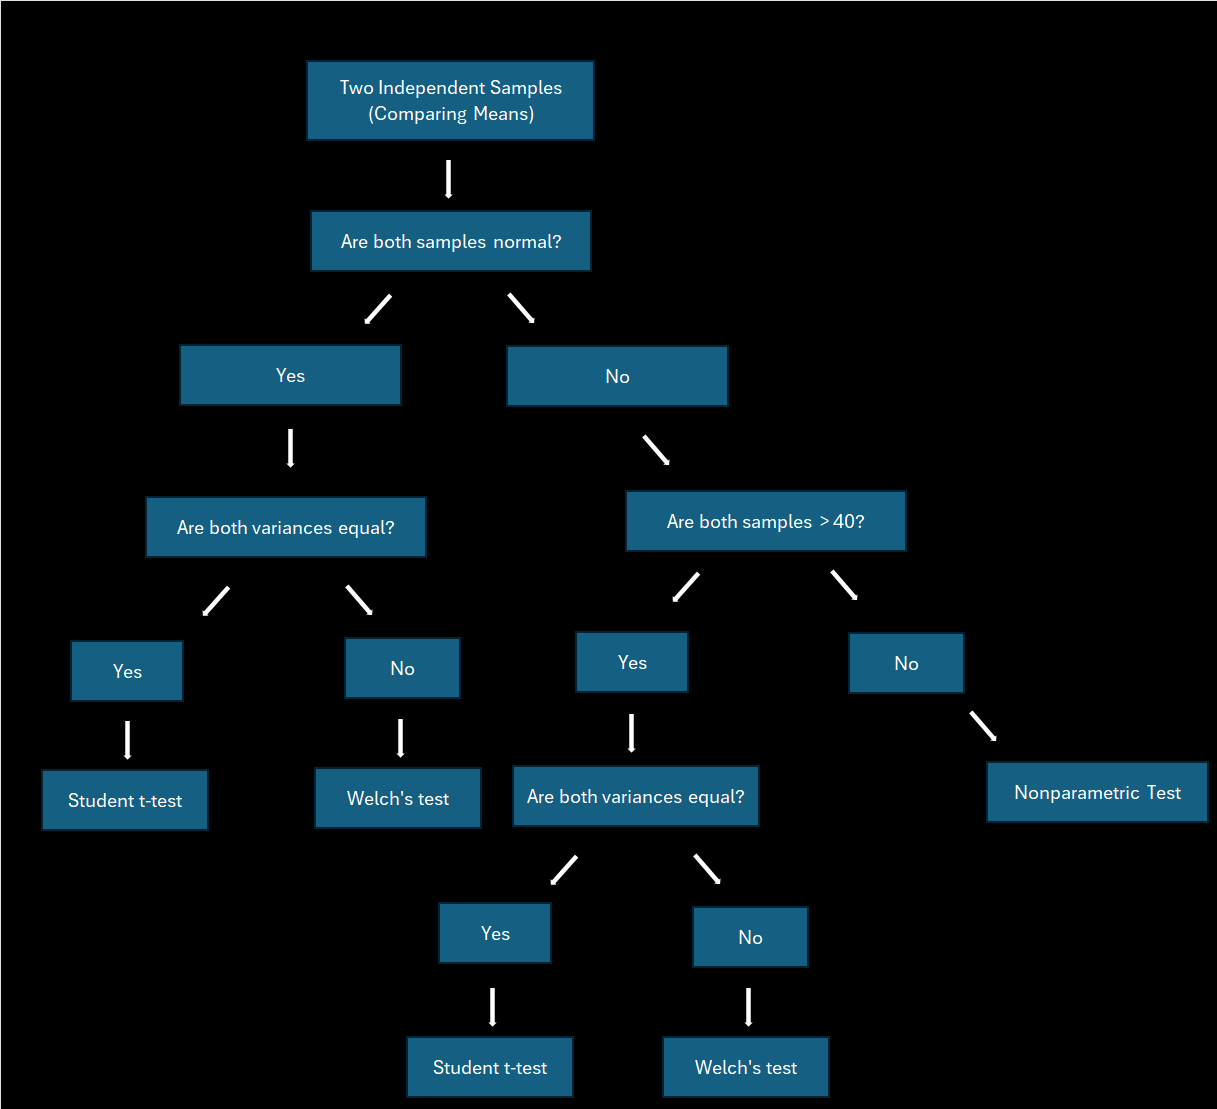

## 6. Checking Assumptions  
Before applying a t-test, we check:  
- Normality: Shapiro-Wilk test, QQ plot.  
- Equal variances: Levene’s test or F-test.  

### 6.1 Normality Check

It is important to verify that the data are approximately normally distributed, since the t-test assumes normality (especially in smaller samples).

#### 6.1.1 Shapiro–Wilk Test:  
  - Null hypothesis (H₀): Data come from a normal distribution.  
  - Alternative (H₁): Data are not normally distributed.  
  - Decision: If p-value < 0.05, reject H₀ (data deviate significantly from normality).

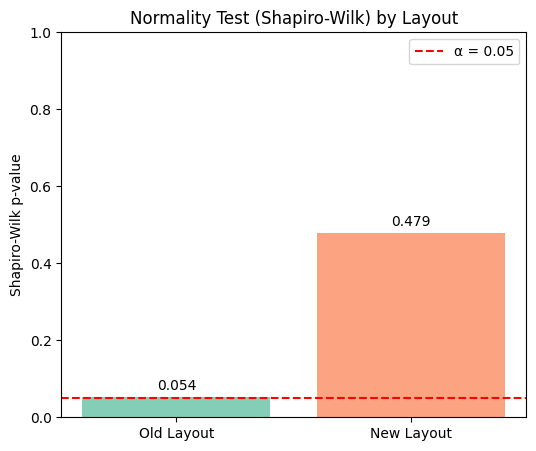


Normality conclusion:
(p_old=0.0538, p_new=0.4793).
Both groups fail to reject normality at α=0.05. Therefore, we can assume both distributions follow a normal distribution.
→ A two-sample t-test (Welch’s) is appropriate for comparing means.


In [37]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Separate groups
old = df[df.layout_type == "old"]["cycle_time_s"]
new = df[df.layout_type == "new"]["cycle_time_s"]

# Run Shapiro-Wilk test
stat_old, p_old = shapiro(old)
stat_new, p_new = shapiro(new)

# Collect results
results = {
    "Old Layout": p_old,
    "New Layout": p_new
}

# --- Visualization ---
plt.figure(figsize=(6,5))
bars = plt.bar(results.keys(), results.values(), color=["#66c2a5","#fc8d62"], alpha=0.8)
plt.axhline(0.05, color="red", linestyle="--", label="α = 0.05")

# Annotate each bar with its p-value
for bar, p in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{p:.3f}", ha="center", va="bottom", fontsize=10)

plt.ylim(0, 1)
plt.ylabel("Shapiro-Wilk p-value")
plt.title("Normality Test (Shapiro-Wilk) by Layout")
plt.legend()
plt.show()


# --- Auto-conclusion
alpha = 0.05
old_norm = p_old >= alpha
new_norm = p_new >= alpha

if old_norm and new_norm:
    conclusion = (
        f"(p_old={p_old:.4f}, p_new={p_new:.4f}).\n"
        f"Both groups fail to reject normality at α={alpha:.2f}. Therefore, we can assume both distributions follow a normal distribution.\n"
        "→ A two-sample t-test (Welch’s) is appropriate for comparing means."
    )
else:
    which = []
    if not old_norm: which.append("Old")
    if not new_norm: which.append("New")
    which = " & ".join(which)
    conclusion = (
        f"(p_old={p_old:.4f}, p_new={p_new:.4f}).\n"
        f"{which} group rejects normality at α={alpha:.2f} "    
        "→ Consider a nonparametric alternative (Mann–Whitney U) or proceed with a "
        "Welch t-test if sample sizes are moderate/large and distributions are similar, "
        "reporting robustness caveats."
    )

print("\nNormality conclusion:")
print(conclusion)



#### 6.1.2 **QQ Plots:**  
  - Visual diagnostic: If the data points follow the diagonal line, the distribution is close to normal.  
  - Deviations at the tails may indicate skewness or outliers.     
- Example:
   - To illustrate the point, we will have a QQ plot for a normally distributed dataset and a heavily skewed (exponential) distributed dataset.

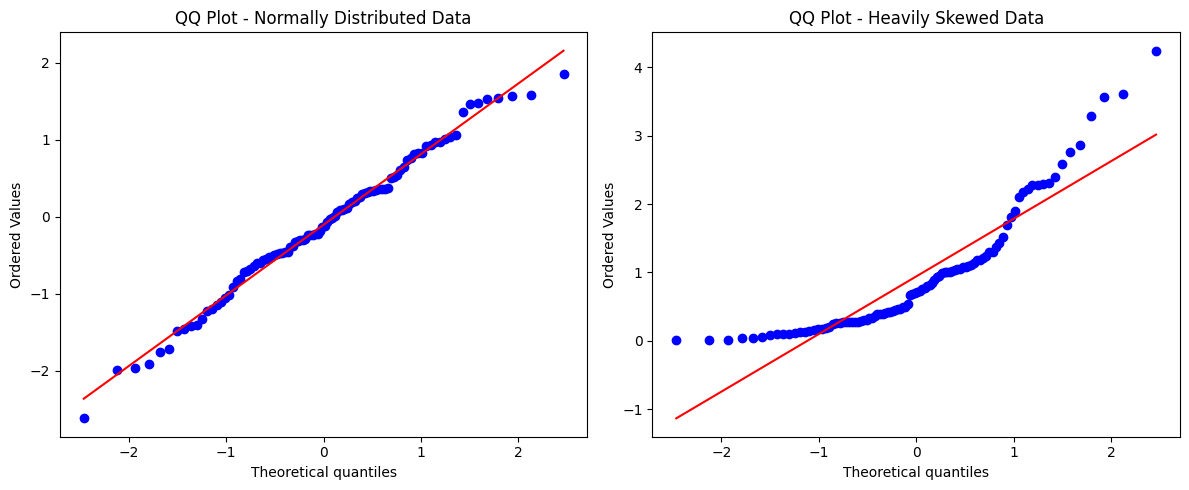

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Generate data
np.random.seed(42)
normal_data = np.random.normal(loc=0, scale=1, size=100)
skewed_data = np.random.exponential(scale=1, size=100)

# Create QQ plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Normal data QQ plot
probplot(normal_data, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot - Normally Distributed Data")

# Skewed data QQ plot
probplot(skewed_data, dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot - Heavily Skewed Data")

plt.tight_layout()
plt.show()


- Old v. New QQ Plot:
   -  Here we see the actual QQ Plots for the old and new layout.

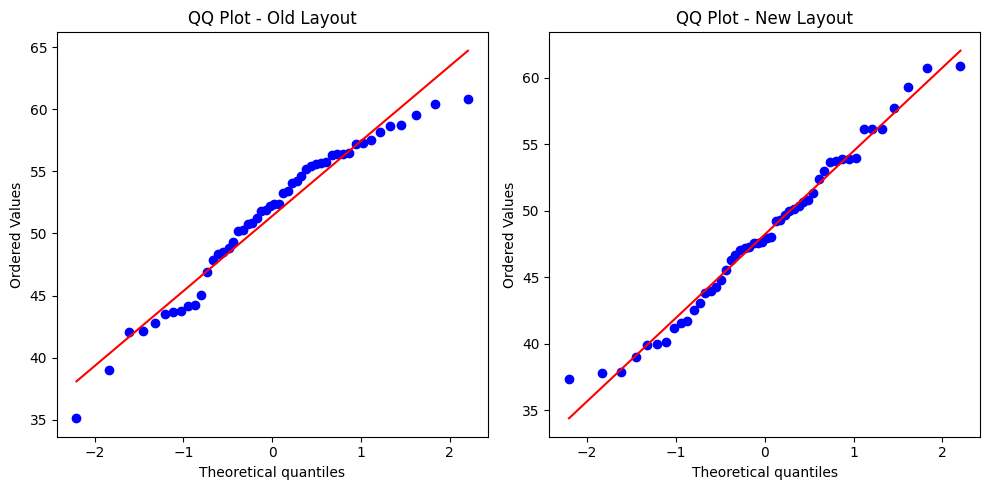

In [31]:
# --- QQ Plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
probplot(old, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot - Old Layout")

probplot(new, dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot - New Layout")

plt.tight_layout()
plt.show()

Both old and new layouts’ cycle time distributions look reasonably Normal since they hug the diagonal line pretty well.
This supports using a t-test to compare the means of the two groups.
 
 
> If not, a nonparametric alternative such as the **Mann–Whitney U test** may be considered.

### 6.2 Equal Variance Check

Equal variance means that the spread (variance) of the data in each group being compared is roughly the same.  
In other words, the groups should not only have different means (if any) but also comparable variability.
- Many parametric tests assume equal variances across groups.  
- If this assumption is violated, test results may be misleading, as the test statistic can become biased.  

In practice, testing for equal variance helps ensure that the statistical conclusions we draw about differences in means are valid and reliable.


#### 6.2.1 Levene’s Test

##### Levene’s Test Hypotheses:  
  - H₀: Variances are equal across groups.  
  - H₁: Variances are not equal.

##### Decision Rule:  
  - If p ≥ 0.05 → Fail to reject H₀ → Assume equal variances.  
    - Use Student’s t-test (pooled variance).  
  - If p < 0.05 → Reject H₀ → Variances differ.  
    - Use Welch’s t-test (robust to unequal variances).

Levene’s Test for Equal Variance
Statistic = 0.010, p-value = 0.9219
Fail to reject H₀ → Variances are equal (homogeneity of variance holds).


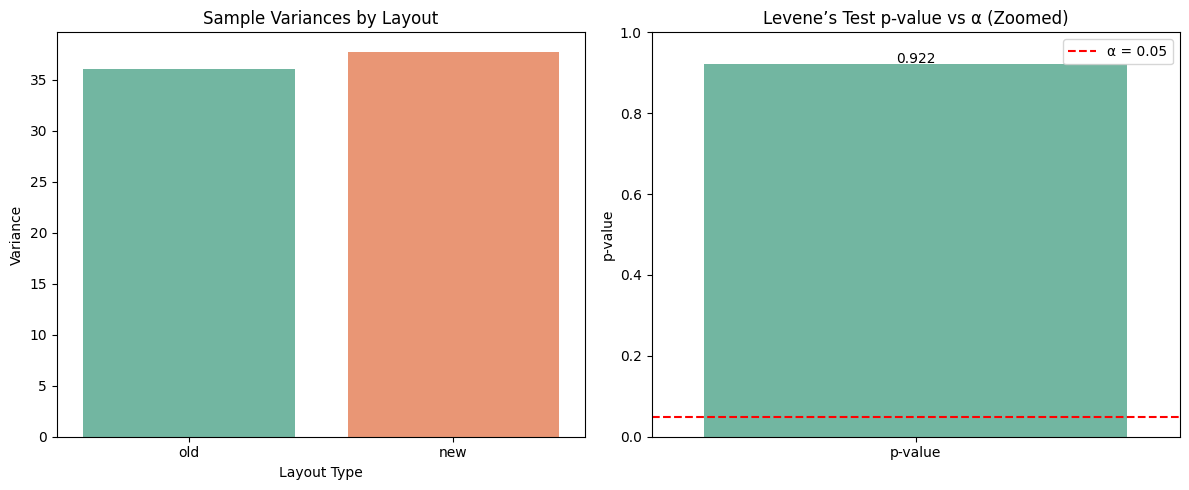

In [60]:
from scipy.stats import levene
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Separate the two groups
old = df[df.layout_type == "old"]["cycle_time_s"]
new = df[df.layout_type == "new"]["cycle_time_s"]

# Levene's Test for Equal Variances
stat, p_value = levene(old, new, center="mean")  # center: "mean", "median", or "trimmed"

print("Levene’s Test for Equal Variance")
print(f"Statistic = {stat:.3f}, p-value = {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value > alpha:
    print("Fail to reject H₀ → Variances are equal (homogeneity of variance holds).")
else:
    print("Reject H₀ → Variances are not equal (heterogeneity of variance).")

# ---------- Visualization (p-value and group variances) ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Group variances (visual context)
var_data = {
    "layout_type": ["old", "new"],
    "variance": [old.var(ddof=1), new.var(ddof=1)]
}
sns.barplot(x="layout_type", y="variance", data=var_data, palette="Set2", ax=axes[0])
axes[0].set_title("Sample Variances by Layout")
axes[0].set_xlabel("Layout Type")
axes[0].set_ylabel("Variance")

# Right: p-value vs alpha (zoomed)
sns.barplot(x=["p-value"], y=[p_value], color="#66c2a5", ax=axes[1])
axes[1].axhline(alpha, color="red", linestyle="--", label=f"α = {alpha}")
axes[1].set_ylim(0, 1)  # Zoom in for clarity (adjust if needed)
axes[1].set_ylabel("p-value")
axes[1].set_title("Levene’s Test p-value vs α (Zoomed)")
axes[1].text(0, p_value + 0.002, f"{p_value:.3f}", ha="center", fontsize=10)
axes[1].legend()

plt.tight_layout()
plt.show()


#### 6.2.2 F-Test

##### F-Test Hypotheses:  
- H₀: Variances are equal across groups.  
- H₁: Variances are not equal.

##### Decision Rule:  
- Compute the test statistic:  
  
  F = (s_1^2)/(s_2^2)
  
  where (s_1^2) and (s_2^2) are the sample variances (larger variance placed in numerator).  

- Under H₀, F follows an F-distribution with degrees of freedom ((n_1-1, n_2-1)).  
- If the p-value < 0.05, reject H₀ and conclude variances differ.  
- If the p-value ≥ 0.05, fail to reject H₀ and assume equal variances.


> Note:  The F-test is sensitive to deviations from normality, so it is best used when both groups are normally distributed.
> In this case, we determined through the Shapiro-Wilk Test and the QQ plot that both groups are normally distributed.



F-Test for Equality of Variances
Numerator: new (df=49), Denominator: old (df=49)
F-statistic = 1.047, p-value = 0.87414
Fail to reject H₀ → Variances are equal. (Homogeneity of variance holds)


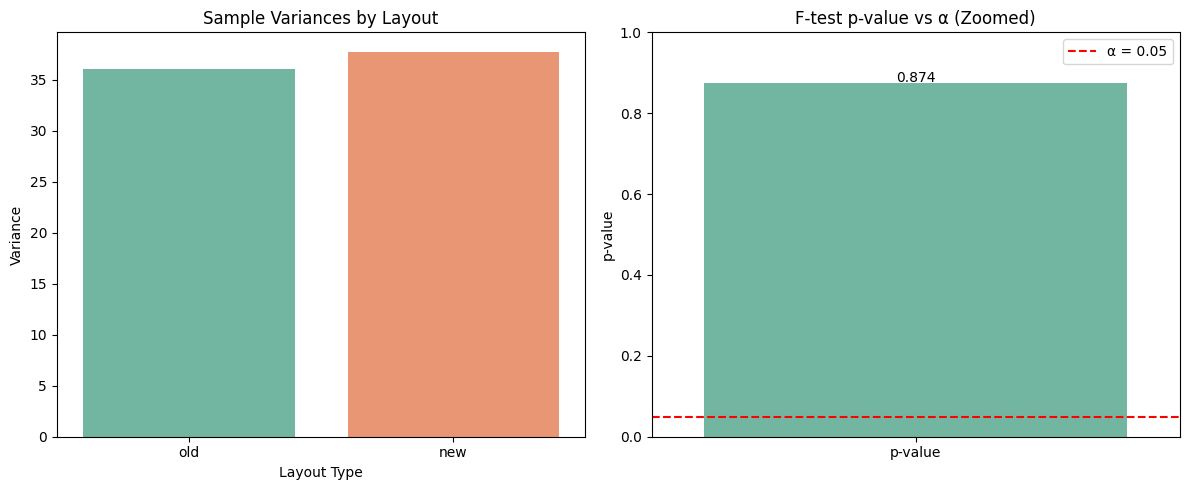

In [59]:
from scipy.stats import f
import seaborn as sns
import matplotlib.pyplot as plt

# Extract groups
old = df[df.layout_type == "old"]["cycle_time_s"]
new = df[df.layout_type == "new"]["cycle_time_s"]

# Sample sizes
n1, n2 = len(old), len(new)

# Sample variances
var1, var2 = old.var(ddof=1), new.var(ddof=1)

# Ensure F >= 1 (place larger variance in numerator)
if var1 >= var2:
    F = var1 / var2
    dfn, dfd = n1 - 1, n2 - 1
    num_group, den_group = "old", "new"
else:
    F = var2 / var1
    dfn, dfd = n2 - 1, n1 - 1
    num_group, den_group = "new", "old"

# Two-tailed p-value
p_value = 2 * min(f.cdf(F, dfn, dfd), 1 - f.cdf(F, dfn, dfd))

print("F-Test for Equality of Variances")
print(f"Numerator: {num_group} (df={dfn}), Denominator: {den_group} (df={dfd})")
print(f"F-statistic = {F:.3f}, p-value = {p_value:.5f}")

alpha = 0.05
if p_value > alpha:
    print("Fail to reject H₀ → Variances are equal. (Homogeneity of variance holds)")
else:
    print("Reject H₀ → Variances differ. (Heterogeneity of variance)")

# ---------- Visualization (zoomed p-value and group variances) ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Sample variances by layout (context)
var_df = {
    "layout_type": ["old", "new"],
    "variance": [var1, var2]
}
sns.barplot(x="layout_type", y="variance", data=var_df, palette="Set2", ax=axes[0])
axes[0].set_title("Sample Variances by Layout")
axes[0].set_xlabel("Layout Type")
axes[0].set_ylabel("Variance")

# Right: p-value vs alpha (zoomed)
sns.barplot(x=["p-value"], y=[p_value], color="#66c2a5", ax=axes[1])
axes[1].axhline(alpha, color="red", linestyle="--", label=f"α = {alpha}")
axes[1].set_ylim(0, 1)  # zoom in for clarity; adjust if p-value > 0.1
axes[1].set_ylabel("p-value")
axes[1].set_title("F-test p-value vs α (Zoomed)")
axes[1].text(0, min(p_value + 0.002, axes[1].get_ylim()[1] - 0.002),
             f"{p_value:.3f}", ha="center", fontsize=10)
axes[1].legend()

plt.tight_layout()
plt.show()


### 6.3 Summary of Assumption Checks

Normality:  
Using the Shapiro–Wilk test (formal) and QQ plots (visual), we determined that both the old and new layout cycle time distributions are approximately normal.  

Equal variances:  
Both Levene’s test and the F-test confirmed that the variances between the two groups are equal.  



#### Next Step

Now we are ready to perform a two-sample Student’s t-test (pooled variance t-test) to compare the means of the cycle times between the old and new job shop layouts.  

- Null Hypothesis (H₀): μ_old = μ_new (no difference in mean cycle time).  
- Alternative Hypothesis (H₁): μ_old > μ_new (old layout has higher mean cycle time).  


## 7. Performing the Hypothesis Test  
We use a two-sample t-test (independent samples):  

- Test Statistic (t): measures difference between group means relative to variability.  
- p-value: probability of observing this difference if H₀ were true.  

Decision Rule:
- If p-value < 0.05 → Reject H₀ (evidence new layout improves performance).  
- If p-value ≥ 0.05 → Fail to reject H₀ (no evidence of improvement).  

Two-Sample Student’s t-test (Equal Variances Assumed)
T-statistic = 2.627, p-value = 0.01001


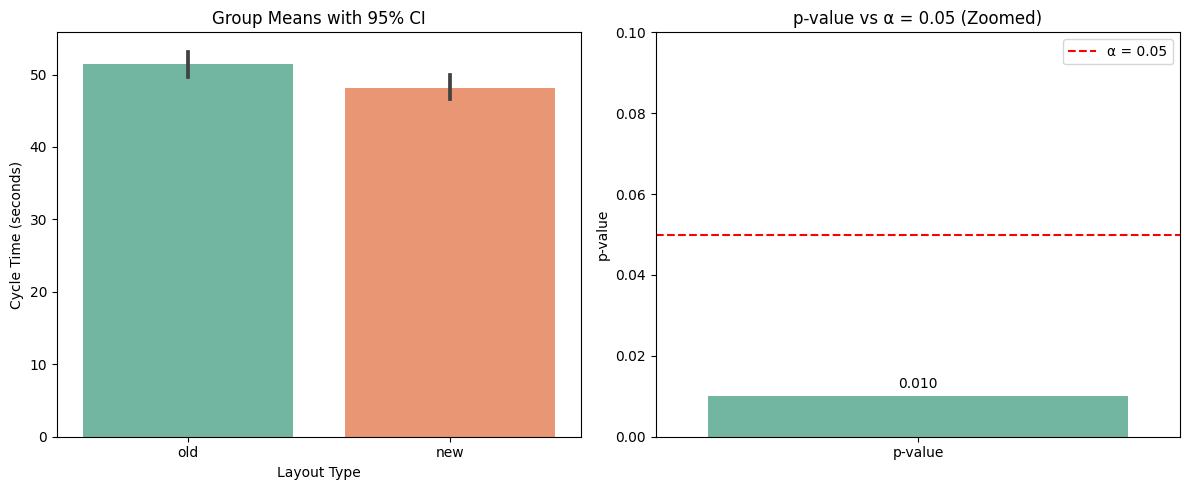

In [52]:
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Separate groups
old = df[df.layout_type == "old"]["cycle_time_s"]
new = df[df.layout_type == "new"]["cycle_time_s"]

# Two-sample t-test (equal variances assumed)
t_stat, p_val = ttest_ind(old, new, equal_var=True)

print("Two-Sample Student’s t-test (Equal Variances Assumed)")
print(f"T-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")

# --- Plot setup
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Left plot: group means with 95% CI
sns.barplot(data=df, x="layout_type", y="cycle_time_s", ci=95, palette="Set2", ax=axes[0])
axes[0].set_title("Group Means with 95% CI")
axes[0].set_ylabel("Cycle Time (seconds)")
axes[0].set_xlabel("Layout Type")

# Right plot: p-value vs alpha threshold (zoomed in)
sns.barplot(x=["p-value"], y=[p_val], color="#66c2a5", ax=axes[1])
axes[1].axhline(0.05, color="red", linestyle="--", label="α = 0.05")
axes[1].set_ylim(0, 0.1)  # zoom in to 0–0.1 range
axes[1].set_ylabel("p-value")
axes[1].set_title("p-value vs α = 0.05 (Zoomed)")

# Annotate bar
axes[1].text(0, p_val + 0.002, f"{p_val:.3f}", ha="center", fontsize=10)

axes[1].legend()

plt.tight_layout()
plt.show()




In [ ]:
# Set significance level
alpha = 0.05

# Decision logic
if p_val < alpha:
    print(f"p-value = {p_val:.5f} < α = {alpha} → Reject H₀: "
          "The new layout has a significantly different mean cycle time.")
else:
    print(f"p-value = {p_val:.5f} ≥ α = {alpha} → Fail to reject H₀: "
          "No significant difference in mean cycle time between layouts.")



## 8. Effect Size & Confidence Intervals

Statistical significance tells us whether a difference exists, but not how large or meaningful that difference is.  
To address this, we use two tools: **effect size** and **confidence intervals**.

### Cohen’s d
Cohen’s d is a standardized measure of effect size.  
It expresses the difference between two means in terms of standard deviation units:  

d = (mean₁ – mean₂) / pooled standard deviation  

- d ≈ 0.2 → small effect  
- d ≈ 0.5 → medium effect  
- d ≈ 0.8+ → large effect  

This helps us understand whether the improvement is practically noticeable, beyond just being statistically significant.

### Confidence Intervals
A 95% confidence interval (CI) around the difference in means provides a range of values within which the true difference likely falls.  
Instead of giving only a single estimate, it shows the precision of our result.  
For example, a CI of [3, 7] seconds means we can be confident the true improvement is somewhere between 3 and 7 seconds per pick.


In [20]:
import numpy as np
from scipy import stats

# Separate groups
old = df[df.layout_type == "old"]["cycle_time_s"]
new = df[df.layout_type == "new"]["cycle_time_s"]

# --- 1. Cohen's d (effect size)
mean_old, mean_new = np.mean(old), np.mean(new)
std_old, std_new = np.std(old, ddof=1), np.std(new, ddof=1)
n1, n2 = len(old), len(new)

# Pooled standard deviation
pooled_std = np.sqrt(((n1-1)*std_old**2 + (n2-1)*std_new**2) / (n1+n2-2))
cohen_d = (mean_old - mean_new) / pooled_std

# --- 2. Confidence interval for difference in means
diff_means = mean_old - mean_new
se = np.sqrt(std_old**2/n1 + std_new**2/n2)
dfree = n1 + n2 - 2
t_crit = stats.t.ppf(0.975, dfree)  # 95% CI

ci_low, ci_high = diff_means - t_crit*se, diff_means + t_crit*se

# --- 3. Translate into practical terms
# Suppose each "unit" produced takes one cycle time
# Time saved per unit = diff_means (seconds)
# Assume ~2000 units per week (example volume, adjust as needed)
units_per_week = 2000
time_saved_seconds = diff_means * units_per_week
time_saved_hours = time_saved_seconds / 3600

print("Effect Size and Practical Interpretation")
print(f"Mean Old Layout = {mean_old:.2f} s")
print(f"Mean New Layout = {mean_new:.2f} s")
print(f"Difference in Means = {diff_means:.2f} s")
print(f"Cohen’s d = {cohen_d:.3f} (effect size)")
print(f"95% CI for Difference = [{ci_low:.2f}, {ci_high:.2f}] seconds")
print(f"Practical Impact: New layout saves ~{diff_means:.1f} seconds per unit.")
print(f"At {units_per_week} units/week → ~{time_saved_hours:.1f} hours saved per week.")


Effect Size and Practical Interpretation
Mean Old Layout = 51.40 s
Mean New Layout = 48.21 s
Difference in Means = 3.19 s
Cohen’s d = 0.525 (effect size)
95% CI for Difference = [0.78, 5.60] seconds
Practical Impact: New layout saves ~3.2 seconds per unit.
At 2000 units/week → ~1.8 hours saved per week.


In the next section, we will translate these results into practical terms:  
what does a difference of a few seconds per pick mean in terms of weekly or monthly operational savings?

## 9. Practical Interpretation of Time Savings

While statistical tests confirm that the new layout reduces average cycle time, the real question in an industrial engineering context is: what does this improvement mean in practice?

Let’s assume the analysis shows that the new layout saves about 3.2 seconds per unit compared to the old layout.

- If the job shop produces 2,000 units per week, the time savings add up to:
  
  2,000 times 3.2 seconds = 6,400 seconds (approx 1.8 hours)
  
- Over a month (4 weeks), this translates to roughly:

  1.8 hours/week times 4 = 7.2 hours saved

- Over a year (50 production weeks), the cumulative effect is:

  1.8 hours/week times 50 = 90 hours saved


### Why this matters
- Higher throughput: With 90 extra hours, the shop could produce additional units without adding labor.  
- Cost savings: Extra labor hours saved can be allocated to other tasks, reducing overtime costs.  
- Lower WIP and shorter lead times: Faster cycle times mean less inventory waiting between stations, aligning output more closely with customer demand.

In short, what seems like a small improvement in seconds per unit translates into over two full work weeks of extra production capacity annually, making the new layout a strategically valuable improvement.

